# %% Importando bibliotecas

In [1]:
# %% Importando bibliotecas
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
#from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

### gerando simulacao simples

In [6]:
import numpy as np
import pandas as pd

np.random.seed(42)  # Fixar semente aleatória para resultados reprodutíveis

def lin_f(x):
    """uma função de dependência linear"""
    return x 

# Coeficientes de ligação
links_coeffs = {
    0: [(0, -1, 0.7), (1, -1, -0.8)],  # X0_t = X0_t-1 *(0.7) + X1_t-1 *(-0.8) (+ erro gaussiano)
    1: [(1, -1, 0.8), (3, -1, 0.8)],   # X1_t = X1_t-1 *(0.8) + X3_t-1 *(0.8) (+ erro gaussiano)
    2: [(2, -1, 0.5), (1, -2, 0.5), (3, -3, 0.6)], # X2_t = X2_t-1 *(0.5) + X1_t-2 *(0.5) + X3_t-3 *(0.6) (+ erro gaussiano)
    3: [(3, -1, 0.4)] # X3_t = # X3_t-1 (+ erro gaussiano)
}

T = 1000   # tamanho da série 

# Gerar dados do processo causal estrutural
data = np.zeros((T, len(links_coeffs)))
"""matriz com a simulação sendo calculada - colunas sao variáveis e linhas sao valores no tempo"""

# Faco a simulacao, e coloco numa matriz "data" o progresso da simulação 
#
for i in range(1, T):
    for var, parents in links_coeffs.items():
        value = sum(coef * data[i + delay, parent] for parent, delay, coef in parents if i + delay >= 0)
        data[i, var] = value + np.random.normal()

# Criar DataFrame com os dados
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
"""nomes das colunas das variáveis"""
datatime = pd.date_range(start='1/1/2025', periods=T)
"""gera datas, comecando em por exemplo 1/jan/2025 """
dataframe = pd.DataFrame(data, index=datatime, columns=var_names)
"""df gerado com a evolução dos valores simulados"""

print(dataframe.head(14))


               $X^0$     $X^1$     $X^2$     $X^3$
2025-01-01  0.000000  0.000000  0.000000  0.000000
2025-01-02  0.496714 -0.138264  0.647689  1.523030
2025-01-03  0.224158  0.873675  1.903057  1.376647
2025-01-04 -1.011504  2.342818  0.418979  0.084929
2025-01-05 -2.340345  0.028917 -0.164773 -0.528316
2025-01-06 -2.674206 -0.085272  1.006986 -1.623630
2025-01-07 -0.338078 -1.592898  0.636437 -2.074200
2025-01-08  0.493281 -2.822756 -1.192400 -0.453982
2025-01-09  2.002862 -2.913084 -2.968534  1.670685
2025-01-10  3.718974 -2.051630 -3.317620 -0.552570
2025-01-11  4.453449 -4.043030 -4.715927 -0.024167
2025-01-12  7.090305 -3.082389 -2.497016 -0.310770
2025-01-13  5.950602 -3.434371 -4.062203  0.932814
2025-01-14  7.256537 -3.764286 -3.262712 -0.011957


## gerando simulacao - paradigma funcional

In [37]:
#@title Inicializando
#@markdown aqui simulamos os dados como nas fórmulas dadas pelo blog

tau_max = 5  # ajustando para levar em conta até o terceiro lag


timestep = 2000

def dyn(x0, x1, x2, x3, history):
    eta = np.random.normal(size=4)
    x0_new = 0.7 * history[0][0] - 0.8 * history[1][1] + eta[0]
    x1_new = 0.8 * history[0][1] + 0.8 * history[0][3] + eta[1]
    x2_new = 0.5 * history[0][2] + 0.5 * history[1][1] + 0.6 * history[2][3] + eta[2]
    x3_new = 0.7 * history[0][3] + eta[3]
    return x0_new, x1_new, x2_new, x3_new
# direita: índice da variável, esquerda: lag + 1: por ex: [1] - > lag= 2
#    X0_t = X0_t-1 *(0.7) + X1_t-1 *(-0.8) (+ erro gaussiano)
#    X1_t = X1_t-1 *(0.8) + X3_t-1 *(0.8) (+ erro gaussiano)
#    X2_t = X2_t-1 *(0.5) + X1_t-2 *(0.5) + X3_t-3 *(0.6) (+ erro gaussiano)
#    X3_t = X3_t-1 (+ erro gaussiano)



x0_ini, x1_ini, x2_ini, x3_ini = np.random.rand(4)   # estado inicial aleatório em "t=1"
history = np.zeros((3, 4))                           # estado incial = 0 para antes disso
history[0] = [x0_ini, x1_ini, x2_ini, x3_ini]


data = np.array([[x0_ini, x1_ini, x2_ini, x3_ini]])

for step in range(1, timestep + 1):  # roda a simulação, enchendo a "data" com uma  lista de lista, em que cada 
    # elemento(lista) representa todas as variáveis para aquele período, e cada elemento reprsenta um período
    x0_ini, x1_ini, x2_ini, x3_ini = dyn(x0_ini, x1_ini, x2_ini, x3_ini, history)
    history = np.roll(history, shift=1, axis=0)
    history[0] = [x0_ini, x1_ini, x2_ini, x3_ini]
    data = np.vstack((data, [x0_ini, x1_ini, x2_ini, x3_ini]))

print(data.shape)  # shape = [timestep+1, 4]

var_names = ['x0', 'x1', 'x2', 'x3']
dataframe = pp.DataFrame(data, datatime=np.arange(len(data)), var_names=var_names)
"""objeto tigramite process data - contém um dataframe com as variáveis no tempo"""



(2001, 4)


'objeto tigramite process data - contém um dataframe com as variáveis no tempo'

In [12]:
data

array([[ 1.03543572e-01,  4.57813650e-01,  3.75794902e-01,
         5.77657996e-01],
       [-2.55314556e-01,  7.86717294e-01,  2.03806110e-01,
         5.84856653e-01],
       [ 6.54687109e-02,  1.06185172e+00, -3.72484023e-02,
         1.81031267e-03],
       ...,
       [ 7.82601275e+00, -5.61730052e+00, -2.99611366e+00,
        -1.72465989e-01],
       [ 1.03509164e+01, -4.24398586e+00, -3.53325738e+00,
         2.57627777e-01],
       [ 1.34530116e+01, -4.80900627e+00, -5.14838497e+00,
         4.63663036e-01]])

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='x0'>, <Axes: ylabel='x1'>, <Axes: ylabel='x2'>,
        <Axes: ylabel='x3'>], dtype=object))

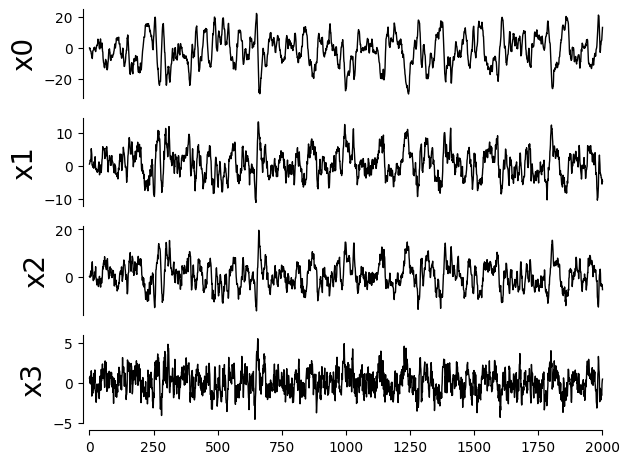

In [ ]:
tp.plot_timeseries(dataframe,label_fontsize=20,tick_label_size=10) 
#biblioteca gráfica do Tigramite, tigramite plotting

In [38]:
pcmci_robust_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=RobustParCorr())

## Comparando grafos - Granger/ orig / PC

In [ ]:

### DEMORADOOO - ver se resíduos são normais
matrix_lags = None

matrix = tp.setup_density_matrix(N=dataframe.N, 
        var_names=dataframe.var_names)

# Standardize to better compare skewness with gaussianized data
dataframe.values[0] -= dataframe.values[0].mean(axis=0)
dataframe.values[0] /= dataframe.values[0].std(axis=0)

matrix.add_densityplot(dataframe=dataframe, 
    matrix_lags=matrix_lags, label_color='red', label="standardized data",
    snskdeplot_args = {'cmap':'Reds', 'alpha':1., 'levels':4})

# Transform data to normal marginals
data_normal = pp.trafo2normal(data)
dataframe_normal = pp.DataFrame(data_normal, var_names=var_names)

matrix.add_densityplot(dataframe=dataframe_normal, 
    matrix_lags=matrix_lags, label_color='black', label="gaussianized data",
    snskdeplot_args = {'cmap':'Greys', 'alpha':1., 'levels':4})
matrix.adjustfig()
plt.show()

In [39]:
from statsmodels.tsa.stattools import grangercausalitytests

def get_granger_links_filtered(data, max_lag, alpha=0.01):
    n_vars = data.shape[1]
    links_granger = {j: [] for j in range(n_vars)}

    for j in range(n_vars):  # destino
        for i in range(n_vars):  # fonte
            if i == j:
                continue
            try:
                test_data = data[:, [j, i]]
                result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
                best_lag = None
                best_pval = 1.0
                for lag in range(1, max_lag + 1):
                    pval = result[lag][0]['ssr_ftest'][1]
                    if pval < best_pval:
                        best_pval = pval
                        best_lag = lag
                if best_pval < alpha:
                    links_granger[j].append((i, -best_lag))
            except Exception as e:
                continue
    return links_granger


# Primeiro tenta com alpha=0.01
links_granger = get_granger_links_filtered(data, max_lag=tau_max, alpha=0.01)

# Se sair tudo vazio, tenta com alpha=0.05
if all(len(v) == 0 for v in links_granger.values()):
    print("Nenhuma aresta com p<0.01. Testando com p<0.05...")
    links_granger = get_granger_links_filtered(data, max_lag=tau_max, alpha=0.05)


c:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [12]:
links_granger

{0: [(1, -1), (2, -1), (3, -1)],
 1: [(0, -1), (2, -1), (3, -1)],
 2: [(0, -1), (1, -1), (3, -1)],
 3: []}

In [40]:
parcorr = ParCorr(significance='analytic')
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr())
results = pcmci_parcorr.run_pcmci(tau_max=5)

pcmci_robust_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=RobustParCorr())
results_robust = pcmci_robust_parcorr.run_pcmci(tau_max=5)

plt.show()

In [15]:
def extract_links(graph: np.ndarray, tau_min: int = 1) -> dict[int, list[tuple[int,int]]]:
    """
    Extrai links do array 'graph' do PCMCI, retornando tuplas invertidas:
      (i, -tau) -> (tau, -i)
    
    Parâmetros
    ----------
    graph : np.ndarray, shape (T, N_targets, N_sources)
        results['graph'] retornado pelo PCMCI.
        T = tau_max+1; N_targets = N_sources = número de variáveis.
    tau_min : int
        Lag mínimo a considerar (e.g. 1 para excluir tau=0).
    
    Retorno
    -------
    links : dict
        Dicionário mapeando cada variável-alvo j a uma lista de tuplas
        (lag, -source_index).
    """
    if graph.ndim != 3:
        raise ValueError(f"Esperado array 3D, mas graph.ndim = {graph.ndim}")
    T, N_targets, N_sources = graph.shape
    links: dict[int, list[tuple[int,int]]] = {j: [] for j in range(N_targets)}
    
    for tau in range(tau_min, T):
        for j in range(N_targets):
            for i in range(N_sources):
                if graph[tau, j, i] == '-->':
                    # adiciona (tau, -i)
                    links[j].append((tau, -i))
    return links

In [100]:
%pip install numpy pandas scipy matplotlib scikit-learn tigramite torch torchvision


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Leo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


(<Figure size 640x480 with 5 Axes>, <Axes: title={'center': 'extraidos '}>)

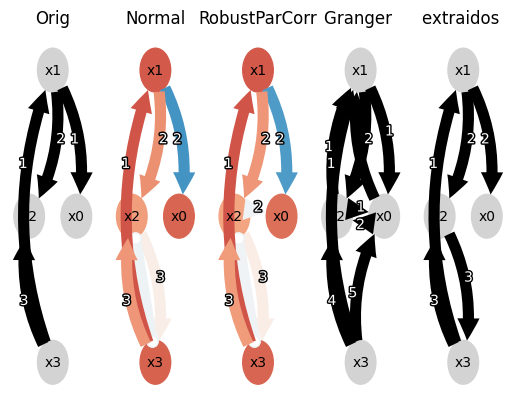

In [41]:

fig, axes = plt.subplots(nrows=1, ncols=5)


links = {
    0: [(0, -1), (1, -1)],         # x0_t depende de x0_{t-1}, x1_{t-1}
    1: [(1, -1), (3, -1)],         # x1_t depende de x1_{t-1}, x3_{t-1}
    2: [(2, -1), (1, -2), (3, -3)],# x2_t depende de x2_{t-1}, x1_{t-2}, x3_{t-3}
    3: [(3, -1)]                   # x3_t depende de x3_{t-1}
}

def extract_links_swapped(graph: np.ndarray, tau_min: int = 1) -> dict[int, list[tuple[int,int]]]:
    """
    Se os eixos estiverem invertidos, ou seja:
      graph[lag, source, target] == '-->'  
      indica source @ t−lag → target @ t
    então usamos esta versão.
    """
    T, N_sources, N_targets = graph.shape
    links = {j: [] for j in range(N_targets)}
    for tau in range(tau_min, T):
        for i in range(N_sources):   # aqui 'i' é o índice da fonte
            for j in range(N_targets):  # e 'j' é o índice do alvo
                if graph[tau, i, j] == '-->':
                    links[j].append((i, -tau))
    return links


extracted_links = extract_links(results["graph"], 0)


axes[0].set_title("Orig")
tp.plot_graph(
    graph=pcmci_robust_parcorr.get_graph_from_dict(links, tau_max=None),
    var_names=var_names,
    fig_ax=(fig, axes[0]),
    show_colorbar=False,
    )




axes[1].set_title("Normal") #ParCorr
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    fig_ax=(fig, axes[1]),
    show_colorbar=False,
    )

axes[2].set_title("RobustParCorr") #RobustParCorr
tp.plot_graph(
    val_matrix=results_robust['val_matrix'],
    graph=results_robust['graph'],
    var_names=var_names,
    fig_ax=(fig, axes[2]),
    show_colorbar=False,
    )


axes[3].set_title("Granger ")

tp.plot_graph(
    graph=pcmci_robust_parcorr.get_graph_from_dict(links_granger, tau_max=None),
    var_names=var_names,
    fig_ax=(fig, axes[3]),
    show_colorbar=False,
)
axes[4].set_title("extraidos ")

tp.plot_graph(
    graph=pcmci_robust_parcorr.get_graph_from_dict(extracted_links, tau_max=None),
    var_names=var_names,
    fig_ax=(fig, axes[4]),
    show_colorbar=False,
)


In [ ]:
def extract_links(graph: np.ndarray, tau_min: int = 1) -> dict[int, list[tuple[int,int]]]:
    """
    Extrai links do array 'graph' do PCMCI, retornando tuplas invertidas:
      (i, -tau) -> (tau, -i)
    
    Parâmetros
    ----------
    graph : np.ndarray, shape (T, N_targets, N_sources)
        results['graph'] retornado pelo PCMCI.
        T = tau_max+1; N_targets = N_sources = número de variáveis.
    tau_min : int
        Lag mínimo a considerar (e.g. 1 para excluir tau=0).
    
    Retorno
    -------
    links : dict
        Dicionário mapeando cada variável-alvo j a uma lista de tuplas
        (lag, -source_index).
    """
    if graph.ndim != 3:
        raise ValueError(f"Esperado array 3D, mas graph.ndim = {graph.ndim}")
    T, N_targets, N_sources = graph.shape
    links: dict[int, list[tuple[int,int]]] = {j: [] for j in range(N_targets)}
    
    for tau in range(tau_min, T):
        for j in range(N_targets):
            for i in range(N_sources):
                if graph[tau, j, i] == '-->':
                    # adiciona (tau, -i)
                    links[j].append((tau, -i))
    return links




extracted_links = extract_links(results['graph'], tau_min=0)

NameError: name 'results' is not defined

## Verificando dentro do PCMCI 

In [16]:
#@markdown Assumindo que nossa causa e efeitos são linearmente dependentes usaremos o teste de correlação parcial especificado com significância='analítica' que assume que a distribuição nula é t de Student
Correlacao_pacial = parcorr.ParCorr(significance='analytic')

# Configurar e executar PCMCI
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=Correlacao_pacial,
    verbosity=1
)


AttributeError: 'ParCorr' object has no attribute 'ParCorr'


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


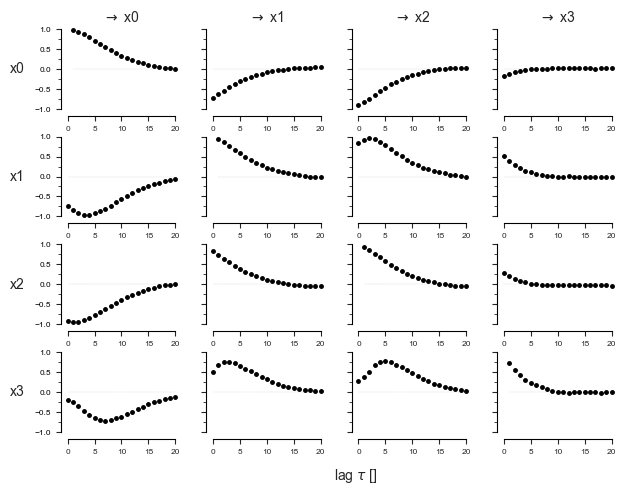

In [ ]:
#@title Aqui ajustamos o parâmetro lag a partir das autocovariâncias
#@markdown 
# 
# A próxima decisão que precisamos tomar é escolher o intervalo de
#  tempo máximo tau_max no qual esperamos o nexo causal mais longo possível.
#  No caso plotamos as correlacoes até 20, e nesse caso em particular 8 parece ser razoável
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names,
                                  'x_base':5, 'y_base':.5})


In [18]:
#@title Agora obtemos os resultados, e plotamos o grafo básico
# Teste de independência (ParCorr)

tau_max=5    ## apesar de recomendar 8, coloco 3 pra ficar mais visível na apresentação


results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],tau_min= 1, tau_max=tau_max, fdr_method='fdr_bh')




NameError: name 'pcmci' is not defined

(<Figure size 400x400 with 1 Axes>, <Axes: >)

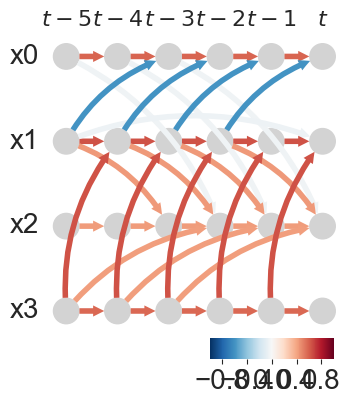

In [54]:
tp.plot_time_series_graph(
    figsize=(4, 4),
    val_matrix=results['val_matrix'],
    graph = results['graph'],
    var_names=var_names,
    link_colorbar_label=None,
    label_fontsize=20,
    tick_label_size=20
)

In [20]:
extracted_links

{0: [(0, -1), (0, -3), (1, -2), (1, -5), (2, -3), (3, -3)],
 1: [(1, -1), (2, -4), (3, -1), (3, -5)],
 2: [(1, -1), (1, -2), (2, -1), (2, -5), (3, -1), (3, -2), (3, -3)],
 3: [(0, -1), (2, -4), (3, -1), (3, -3)]}

In [21]:
## Preparaão dos Dados: 

import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, L):
        # data: array [T, N]
        self.L = L
        self.X = torch.from_numpy(data).float()
    def __len__(self):
        return len(self.X) - self.L
    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.L]          # shape (L, N)
        y      = self.X[idx + self.L]               # shape (N,)
        return x_seq, y

# Exemplo:
L = 5   # lag máximo
dataset = TimeSeriesDataset(data, L)
loader  = DataLoader(dataset, batch_size=64, shuffle=True)


In [22]:
### modelo básico: 
import torch.nn as nn

class BaselineLSTM(nn.Module):
    def __init__(self, N, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=N, hidden_size=hidden_size, batch_first=True)
        self.out  = nn.Linear(hidden_size, N)
    def forward(self, x):      # x: (B, L, N)
        _, (h_n, _) = self.lstm(x)      # h_n: (1, B, hidden_size)
        h = h_n.squeeze(0)              # (B, hidden_size)
        return self.out(h)              # (B, N)


In [23]:
## modelo penalizado via inform dos gradientes: 
class PhysicsInformedLSTM(nn.Module):
    def __init__(self, N, hidden_size, extracted_links, L, device):
        super().__init__()
        self.N = N
        self.L = L
        self.device = device
        self.base = BaselineLSTM(N, hidden_size).to(device)
        # Construir máscara (L, N, N)
        mask = torch.ones(L, N, N, dtype=torch.bool)
        for j, links in extracted_links.items():
            for (i, neg_tau) in links:
                τ = -neg_tau
                mask[τ-1, i, j] = False  # existe aresta: não penalizar
        self.register_buffer('mask_non_edge', mask)  # True = penalizar
        self.lambda_reg = 1e-2  # peso da penalização

    def forward(self, x):
        x = x.requires_grad_(True)    # para poder calcular ∂ŷ/∂x
        y_pred = self.base(x)         # (B, N)
        return y_pred, x

    def physics_penalty(self, y_pred, x):
        # y_pred: (B, N), x: (B, L, N)
        penalty = 0.0
        B = y_pred.shape[0]
        # Para cada variável de saída j:
        for j in range(self.N):
            # grad_j: ∂ sum_b y_pred[b,j] / ∂ x
            grad_j = torch.autograd.grad(
                y_pred[:, j].sum(), x, create_graph=True
            )[0]   # shape (B, L, N)
            # só soma onde mask_non_edge == True
            m = self.mask_non_edge.to(x.device)   # (L, N, N)
            # queremos penalizar ∂y_j/∂x_i[τ] se m[τ,i,j]==True
            # expandir grad_j para (B, L, N, 1) e mask para (1,L,N,N)
            g = grad_j.unsqueeze(-1)              # (B,L,N,1)
            m_j = m[..., j]                        # (L, N)
            pen_j = (g.squeeze(-1)**2 * m_j).sum()
            penalty += pen_j
        # normalizar por batch
        return self.lambda_reg * penalty / B


In [24]:
def train(model, loader, opt, epochs):
    mse_loss = nn.MSELoss()
    for epoch in range(epochs):
        total_mse, total_pen, n = 0, 0, 0
        for x_seq, y in loader:
            x_seq, y = x_seq.to(device), y.to(device)
            opt.zero_grad()
            if isinstance(model, PhysicsInformedLSTM):
                y_pred, x_req = model(x_seq)
                loss_mse = mse_loss(y_pred, y)
                loss_pen = model.physics_penalty(y_pred, x_req)
                loss = loss_mse + loss_pen
                total_pen += loss_pen.item()
            else:
                y_pred = model(x_seq)
                loss = mse_loss(y_pred, y)
            loss.backward()
            opt.step()
            total_mse += mse_loss(y_pred, y).item()
            n += 1
        print(f"Epoch {epoch}: MSE={total_mse/n:.4f}"
              + (f"  Pen={total_pen/n:.4f}" if total_pen else ""))


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden = 32

# Baseline
baseline = BaselineLSTM(N=4, hidden_size=hidden).to(device)
opt_b = torch.optim.Adam(baseline.parameters(), lr=1e-3)
train(baseline, loader, opt_b, epochs=20)

# Physics-informed
pi_lstm = PhysicsInformedLSTM(
    N=4, hidden_size=hidden,
    extracted_links=extracted_links,
    L=L, device=device
)
opt_p = torch.optim.Adam(pi_lstm.parameters(), lr=1e-3)
train(pi_lstm, loader, opt_p, epochs=20)


Epoch 0: MSE=3.1974
Epoch 1: MSE=1.0617
Epoch 2: MSE=1.0326
Epoch 3: MSE=1.0247
Epoch 4: MSE=1.0221
Epoch 5: MSE=1.0196
Epoch 6: MSE=1.0182
Epoch 7: MSE=1.0173
Epoch 8: MSE=1.0161
Epoch 9: MSE=1.0154
Epoch 10: MSE=1.0153
Epoch 11: MSE=1.0138
Epoch 12: MSE=1.0136
Epoch 13: MSE=1.0131
Epoch 14: MSE=1.0129
Epoch 15: MSE=1.0122
Epoch 16: MSE=1.0121
Epoch 17: MSE=1.0119
Epoch 18: MSE=1.0116
Epoch 19: MSE=1.0113
Epoch 0: MSE=3.2430  Pen=0.0172
Epoch 1: MSE=1.0632  Pen=0.0235
Epoch 2: MSE=1.0331  Pen=0.0233
Epoch 3: MSE=1.0260  Pen=0.0233
Epoch 4: MSE=1.0225  Pen=0.0232
Epoch 5: MSE=1.0208  Pen=0.0232
Epoch 6: MSE=1.0191  Pen=0.0232
Epoch 7: MSE=1.0178  Pen=0.0232
Epoch 8: MSE=1.0174  Pen=0.0232
Epoch 9: MSE=1.0168  Pen=0.0232
Epoch 10: MSE=1.0162  Pen=0.0232
Epoch 11: MSE=1.0152  Pen=0.0232
Epoch 12: MSE=1.0140  Pen=0.0232
Epoch 13: MSE=1.0143  Pen=0.0232
Epoch 14: MSE=1.0138  Pen=0.0231
Epoch 15: MSE=1.0137  Pen=0.0232
Epoch 16: MSE=1.0134  Pen=0.0232
Epoch 17: MSE=1.0131  Pen=0.0231
Epoch 


Variável x0:
  Baseline —  MSE: 1.0351, MAE: 0.8104, R²: 0.9880
  PhysInformed —  MSE: 1.0192, MAE: 0.8049, R²: 0.9882

Variável x1:
  Baseline —  MSE: 1.0120, MAE: 0.8022, R²: 0.9339
  PhysInformed —  MSE: 1.0201, MAE: 0.8060, R²: 0.9334

Variável x2:
  Baseline —  MSE: 1.0069, MAE: 0.7991, R²: 0.9586
  PhysInformed —  MSE: 1.0121, MAE: 0.8013, R²: 0.9584

Variável x3:
  Baseline —  MSE: 1.0005, MAE: 0.7973, R²: 0.4885
  PhysInformed —  MSE: 1.0060, MAE: 0.7997, R²: 0.4857


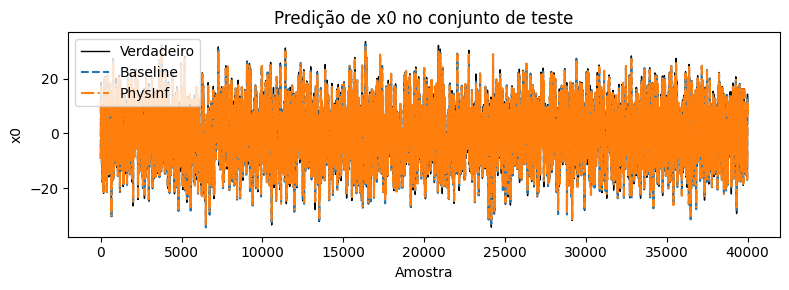

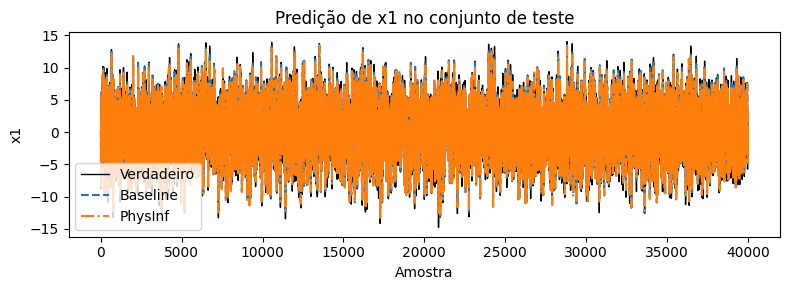

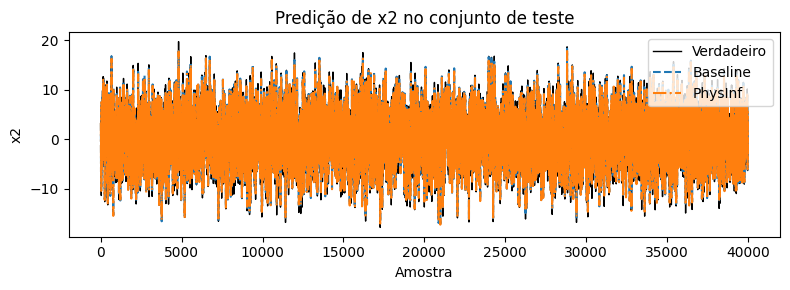

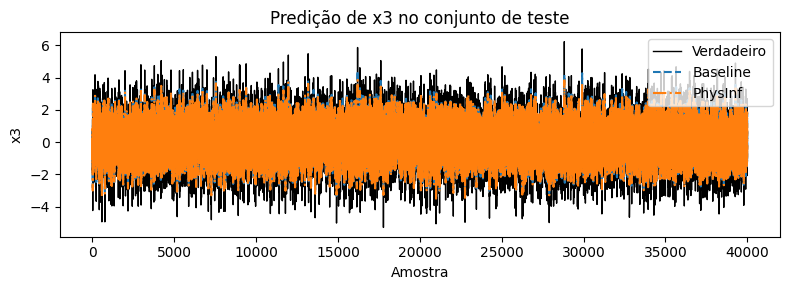

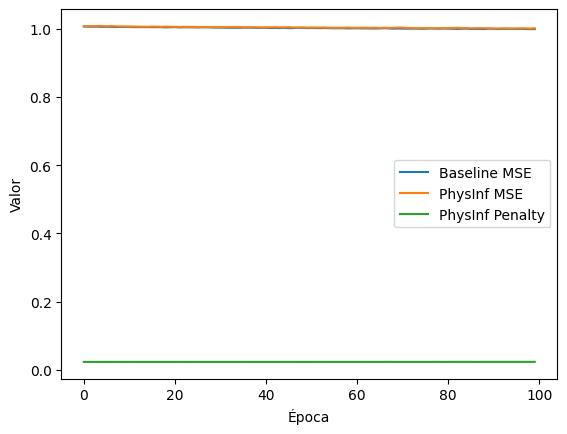

In [28]:
# supondo data: numpy array [T+1, N] e L o lag
T = data.shape[0] - 1
split_idx = int(0.8 * T)  # 80% treino, 20% teste

train_data = data[: split_idx + L + 1]   # +1 porque dataset usa len = T-L
test_data  = data[ split_idx : ]

train_ds = TimeSeriesDataset(train_data, L)
test_ds  = TimeSeriesDataset(test_data,  L)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)


import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(model, loader, physics=False):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_seq, y in loader:
            x_seq, y = x_seq.to(device), y.to(device)
            if physics:
                y_hat, _ = model(x_seq)
            else:
                y_hat = model(x_seq)
            preds.append(y_hat.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.vstack(preds)  # (n_samples, N)
    trues = np.vstack(trues)
    # métricas por variável
    mses = mean_squared_error(trues, preds, multioutput='raw_values')
    maes = mean_absolute_error(trues, preds, multioutput='raw_values')
    r2s  = r2_score(trues, preds, multioutput='raw_values')
    return preds, trues, mses, maes, r2s

# rodar avaliação
b_preds, b_trues, b_mse, b_mae, b_r2 = evaluate(baseline,  test_loader, physics=False)
p_preds, p_trues, p_mse, p_mae, p_r2 = evaluate(pi_lstm,   test_loader, physics=True)


for j, name in enumerate(var_names):
    print(f"\nVariável {name}:")
    print(f"  Baseline —  MSE: {b_mse[j]:.4f}, MAE: {b_mae[j]:.4f}, R²: {b_r2[j]:.4f}")
    print(f"  PhysInformed —  MSE: {p_mse[j]:.4f}, MAE: {p_mae[j]:.4f}, R²: {p_r2[j]:.4f}")

import matplotlib.pyplot as plt

# Montar eixo de tempo relativo ao teste
t_test = np.arange(len(b_trues))

for j, name in enumerate(var_names):
    plt.figure(figsize=(8,3))
    plt.plot(t_test, b_trues[:, j], label='Verdadeiro', color='k', linewidth=1)
    plt.plot(t_test, b_preds[:, j], label='Baseline',   linestyle='--')
    plt.plot(t_test, p_preds[:, j], label='PhysInf',    linestyle='-.')
    plt.title(f"Predição de {name} no conjunto de teste")
    plt.xlabel("Amostra")
    plt.ylabel(name)
    plt.legend()
    plt.tight_layout()
    plt.show()



def train_history(model, loader, opt, epochs, physics=False):
    history = {'mse': [], 'pen': []}
    mse_loss = nn.MSELoss()
    for ep in range(epochs):
        tot_mse, tot_pen, n = 0, 0, 0
        for x_seq, y in loader:
            x_seq, y = x_seq.to(device), y.to(device)
            opt.zero_grad()
            if physics:
                y_hat, x_req = model(x_seq)
                loss_mse = mse_loss(y_hat, y)
                loss_pen = model.physics_penalty(y_hat, x_req)
                loss = loss_mse + loss_pen
                tot_pen += loss_pen.item()
            else:
                y_hat = model(x_seq)
                loss = mse_loss(y_hat, y)
            loss.backward()
            opt.step()
            tot_mse += loss_mse.item() if physics else loss.item()
            n += 1
        history['mse'].append(tot_mse/n)
        if physics:
            history['pen'].append(tot_pen/n)
    return history

# Exemplo de uso:
hist_b = train_history(baseline,  train_loader, opt_b, epochs=100, physics=False)
hist_p = train_history(pi_lstm,   train_loader, opt_p, epochs=100, physics=True)

# Plotar:
plt.plot(hist_b['mse'], label='Baseline MSE')
plt.plot(hist_p['mse'], label='PhysInf MSE')
plt.plot(hist_p['pen'], label='PhysInf Penalty')
plt.xlabel("Época")
plt.ylabel("Valor")
plt.legend()
plt.show()


=== MSE médio por horizonte ===
Horizonte 1 passo à frente:
  Baseline MSE:       1.0422
  Phys-Informed MSE:  1.0351

Horizonte 2 passo à frente:
  Baseline MSE:       1.6658
  Phys-Informed MSE:  1.6441

Horizonte 3 passo à frente:
  Baseline MSE:       2.4507
  Phys-Informed MSE:  2.4199

Horizonte 4 passo à frente:
  Baseline MSE:       3.7985
  Phys-Informed MSE:  3.7452

Horizonte 5 passo à frente:
  Baseline MSE:       5.8755
  Phys-Informed MSE:  5.7671

Horizonte 6 passo à frente:
  Baseline MSE:       8.6344
  Phys-Informed MSE:  8.4370

Horizonte 7 passo à frente:
  Baseline MSE:       11.8702
  Phys-Informed MSE:  11.5233

Horizonte 8 passo à frente:
  Baseline MSE:       15.1236
  Phys-Informed MSE:  14.5566

Horizonte 9 passo à frente:
  Baseline MSE:       18.1155
  Phys-Informed MSE:  17.3264

Horizonte 10 passo à frente:
  Baseline MSE:       20.7060
  Phys-Informed MSE:  19.6713

Horizonte 11 passo à frente:
  Baseline MSE:       22.7775
  Phys-Informed MSE:  21.5259


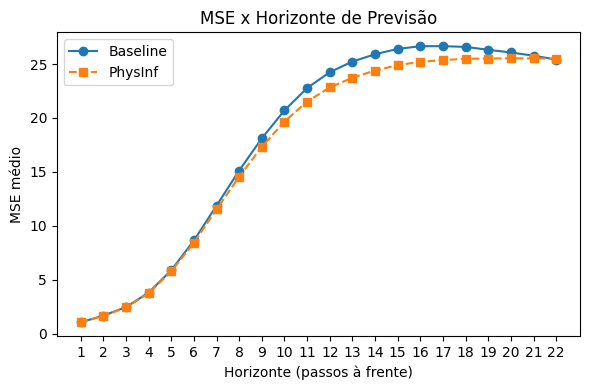

In [33]:
# --------------------------------------------------
# 1) Gerar nova série de teste (mesmo processo sintético)
# --------------------------------------------------
import numpy as np
import torch

t_test2 = 500
# inicialização aleatória
x0_cur, x1_cur, x2_cur, x3_cur = np.random.rand(4)
history = np.zeros((L, 4))
history[0] = [x0_cur, x1_cur, x2_cur, x3_cur]
data_test2 = np.array([[x0_cur, x1_cur, x2_cur, x3_cur]])

for _ in range(1, t_test2 + 1):
    x0_cur, x1_cur, x2_cur, x3_cur = dyn(x0_cur, x1_cur, x2_cur, x3_cur, history)
    history = np.roll(history, shift=1, axis=0)
    history[0] = [x0_cur, x1_cur, x2_cur, x3_cur]
    data_test2 = np.vstack((data_test2, [x0_cur, x1_cur, x2_cur, x3_cur]))

# --------------------------------------------------
# 2) Função para previsão iterativa de h passos
# --------------------------------------------------
def forecast_horizon(model, init_seq, h):
    """
    init_seq: tensor (L, N) com os últimos L lags
    h: horizonte inteiro >=1
    retorna: list de h arrays (N,) com previsões passo-a-passo
    """
    model.eval()
    seq = init_seq.clone().detach().to(device)     # (L, N)
    preds = []
    with torch.no_grad():
        for step in range(h):
            x_in = seq.unsqueeze(0)                  # (1, L, N)
            if isinstance(model, PhysicsInformedLSTM):
                y_hat, _ = model(x_in)
            else:
                y_hat = model(x_in)
            y_hat = y_hat.squeeze(0)                 # (N,)
            preds.append(y_hat.cpu().numpy())
            # atualizar sequência de entrada: descartar lag mais antigo, acrescentar y_hat
            seq = torch.cat([seq[1:], y_hat.unsqueeze(0)], dim=0)
    return preds

# --------------------------------------------------
# 3) Avaliar MSE para horizontes 1, 2 e 3
# --------------------------------------------------
from collections import defaultdict

horizons = [1, 2, 3, 4, 5, 6 ,7 ,8 ,9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
mse_b = defaultdict(list)
mse_p = defaultdict(list)

# percorrer cada ponto possível no test set
max_h = max(horizons)
for idx in range(L, len(data_test2) - max_h):
    init = torch.from_numpy(data_test2[idx - L: idx]).float()
    # predição baseline e physinf
    preds_b = forecast_horizon(baseline, init, max_h)
    preds_p = forecast_horizon(pi_lstm,   init, max_h)
    # verdade para cada horizonte
    true_seq = data_test2[idx : idx + max_h]  # shape (max_h, N)
    for h in horizons:
        # MSE no passo h: (preds[h-1] vs true_seq[h-1])
        err_b = ((preds_b[h-1] - true_seq[h-1])**2).mean()
        err_p = ((preds_p[h-1] - true_seq[h-1])**2).mean()
        mse_b[h].append(err_b)
        mse_p[h].append(err_p)

# --------------------------------------------------
# 4) Mostrar resultados agregados
# --------------------------------------------------
print("=== MSE médio por horizonte ===")
for h in horizons:
    print(f"Horizonte {h} passo à frente:")
    print(f"  Baseline MSE:       {np.mean(mse_b[h]):.4f}")
    print(f"  Phys-Informed MSE:  {np.mean(mse_p[h]):.4f}")
    print()

# --------------------------------------------------
# 5) Plotar MSE vs. horizonte
# --------------------------------------------------
import matplotlib.pyplot as plt

means_b = [np.mean(mse_b[h]) for h in horizons]
means_p = [np.mean(mse_p[h]) for h in horizons]

plt.figure(figsize=(6,4))
plt.plot(horizons, means_b, 'o-', label='Baseline')
plt.plot(horizons, means_p, 's--', label='PhysInf')
plt.xticks(horizons)
plt.xlabel("Horizonte (passos à frente)")
plt.ylabel("MSE médio")
plt.title("MSE x Horizonte de Previsão")
plt.legend()
plt.tight_layout()
plt.show()


Epoch 0: MSE=0.2571
Epoch 1: MSE=0.2102
Epoch 2: MSE=0.1626
Epoch 3: MSE=0.1110
Epoch 4: MSE=0.0741
Epoch 5: MSE=0.0600
Epoch 6: MSE=0.0502
Epoch 7: MSE=0.0433
Epoch 8: MSE=0.0350
Epoch 9: MSE=0.0293
Epoch 10: MSE=0.0257
Epoch 11: MSE=0.0238
Epoch 12: MSE=0.0227
Epoch 13: MSE=0.0221
Epoch 14: MSE=0.0212
Epoch 15: MSE=0.0207
Epoch 16: MSE=0.0202
Epoch 17: MSE=0.0196
Epoch 18: MSE=0.0191
Epoch 19: MSE=0.0188
Epoch 20: MSE=0.0180
Epoch 21: MSE=0.0179
Epoch 22: MSE=0.0177
Epoch 23: MSE=0.0172
Epoch 24: MSE=0.0169
Epoch 25: MSE=0.0166
Epoch 26: MSE=0.0161
Epoch 27: MSE=0.0159
Epoch 28: MSE=0.0156
Epoch 29: MSE=0.0155
Epoch 30: MSE=0.0152
Epoch 31: MSE=0.0148
Epoch 32: MSE=0.0147
Epoch 33: MSE=0.0144
Epoch 34: MSE=0.0141
Epoch 35: MSE=0.0141
Epoch 36: MSE=0.0141
Epoch 37: MSE=0.0136
Epoch 38: MSE=0.0136
Epoch 39: MSE=0.0134
Epoch 40: MSE=0.0134
Epoch 41: MSE=0.0132
Epoch 42: MSE=0.0131
Epoch 43: MSE=0.0130
Epoch 44: MSE=0.0129
Epoch 45: MSE=0.0128
Epoch 46: MSE=0.0128
Epoch 47: MSE=0.0127
Ep

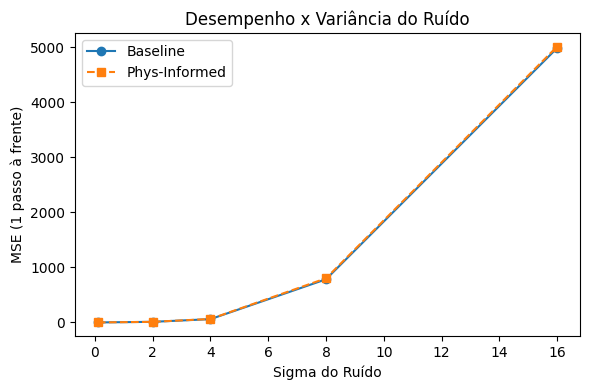

In [36]:
# --------------------------------------------------
# Experimento: MSE 1-passo à frente vs. variância do ruído
# --------------------------------------------------

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error

# Parâmetros gerais
device = 'cuda' if torch.cuda.is_available() else 'cpu'
L = 5                     # mesmo lag usado antes
hidden = 32               # tamanho do hidden state
epochs = 100               # ajustar conforme necessidade
T = 1000                  # tamanho de cada série
noise_levels = [0.1, 2.0, 4.0, 8.0 , 16.0 ]

# Função dyn com variância escalável
def dyn_noise(x0, x1, x2, x3, history, sigma):
    eta = np.random.normal(scale=sigma, size=4)
    x0_new = 0.7 * history[0][0] - 0.8 * history[1][1] + eta[0]
    x1_new = 0.8 * history[0][1] + 0.8 * history[0][3] + eta[1]
    x2_new = 0.5 * history[0][2] + 0.5 * history[1][1] + 0.6 * history[2][3] + eta[2]
    x3_new = 0.7 * history[0][3] + eta[3]
    return x0_new, x1_new, x2_new, x3_new

# Armazenar resultados
mse_baseline = []
mse_physinf = []

for sigma in noise_levels:
    # 1) Simular dados com ruído sigma
    history = np.zeros((L, 4))
    x_cur = np.random.rand(4)
    history[0] = x_cur.copy()
    data = x_cur.reshape(1,4)
    for _ in range(T):
        x_cur = dyn_noise(*x_cur, history, sigma)
        history = np.roll(history, shift=1, axis=0)
        history[0] = x_cur
        data = np.vstack((data, x_cur))
    
    # 2) Criar dataset e loader
    ds = TimeSeriesDataset(data, L)
    split = int(0.8 * len(ds))
    train_ds, test_ds = torch.utils.data.random_split(ds, [split, len(ds)-split])
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)
    
    # 3) Instanciar modelos limpo
    base = BaselineLSTM(N=4, hidden_size=hidden).to(device)
    phys = PhysicsInformedLSTM(N=4, hidden_size=hidden, extracted_links=extracted_links, L=L, device=device)
    opt_b = torch.optim.Adam(base.parameters(), lr=1e-3)
    opt_p = torch.optim.Adam(phys.parameters(), lr=1e-3)
    
    # 4) Treinar rápido
    train(base, train_loader, opt_b, epochs)
    train(phys, train_loader, opt_p, epochs)
    
    # 5) Avaliar MSE 1-passo à frente
    def eval1(model, loader, physics=False):
        model.eval()
        ys, yhs = [], []
        with torch.no_grad():
            for x_seq, y in loader:
                x_seq, y = x_seq.to(device), y.to(device)
                y_hat = model(x_seq)[0] if physics else model(x_seq)
                ys.append(y.cpu().numpy())
                yhs.append(y_hat.cpu().numpy())
        ys, yhs = np.vstack(ys), np.vstack(yhs)
        return mean_squared_error(ys, yhs)
    
    mse_baseline.append(eval1(base, test_loader, physics=False))
    mse_physinf.append(eval1(phys, test_loader, physics=True))

# 6) Plotar MSE vs. sigma
plt.figure(figsize=(6,4))
plt.plot(noise_levels, mse_baseline, 'o-', label='Baseline')
plt.plot(noise_levels, mse_physinf, 's--', label='Phys-Informed')
plt.xlabel("Sigma do Ruído")
plt.ylabel("MSE (1 passo à frente)")
plt.title("Desempenho x Variância do Ruído")
plt.legend()
plt.tight_layout()
plt.show()


=== Métricas de Desempenho (Teste) ===

Variável x0:
  Baseline       → MSE: 1.0351, MAE: 0.8104, R²: 0.9880
  Phys-Informed  → MSE: 1.0192, MAE: 0.8049, R²: 0.9882

Variável x1:
  Baseline       → MSE: 1.0120, MAE: 0.8022, R²: 0.9339
  Phys-Informed  → MSE: 1.0201, MAE: 0.8060, R²: 0.9334

Variável x2:
  Baseline       → MSE: 1.0069, MAE: 0.7991, R²: 0.9586
  Phys-Informed  → MSE: 1.0121, MAE: 0.8013, R²: 0.9584

Variável x3:
  Baseline       → MSE: 1.0005, MAE: 0.7973, R²: 0.4885
  Phys-Informed  → MSE: 1.0060, MAE: 0.7997, R²: 0.4857


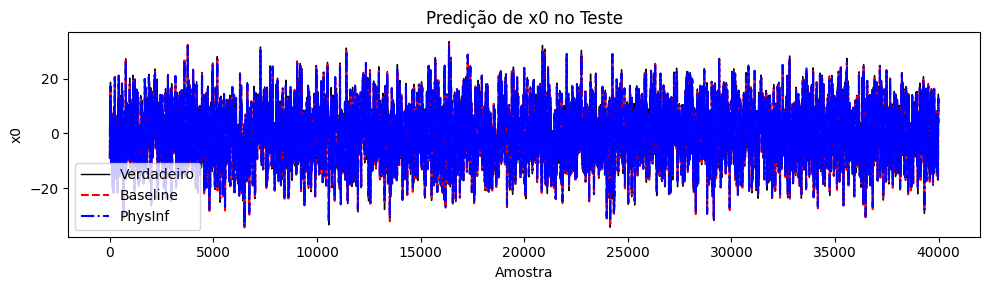

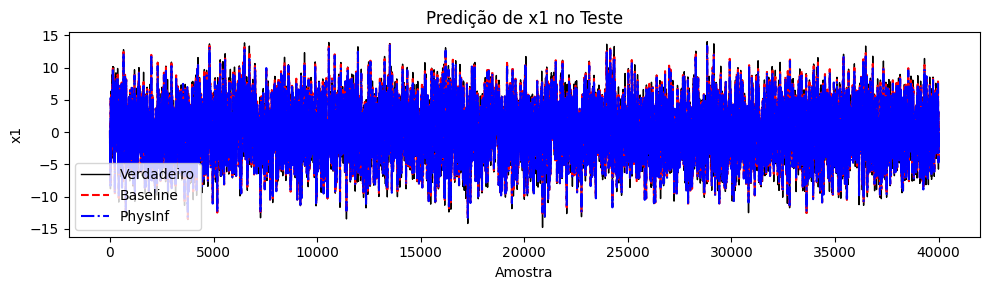

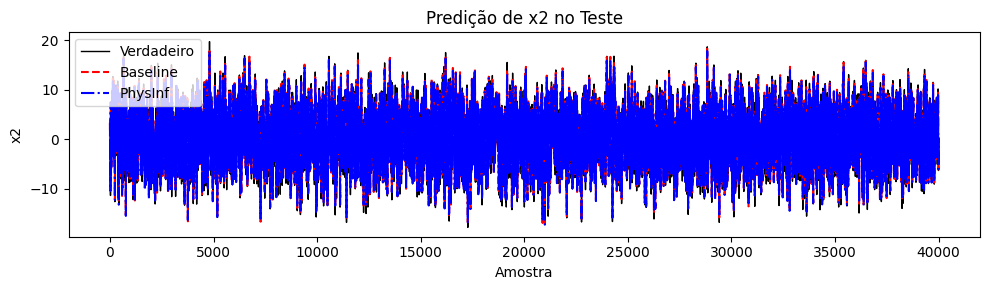

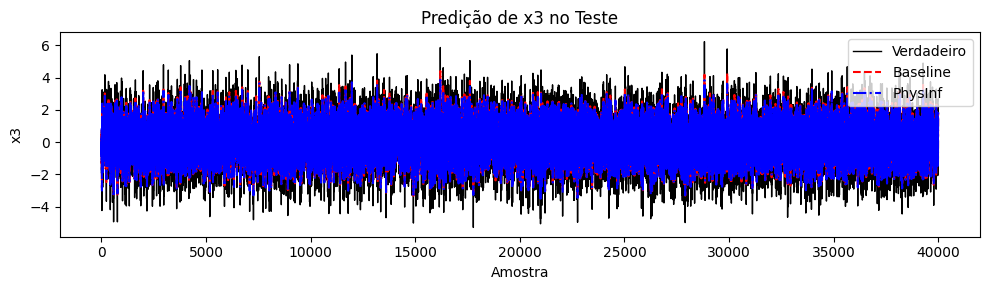

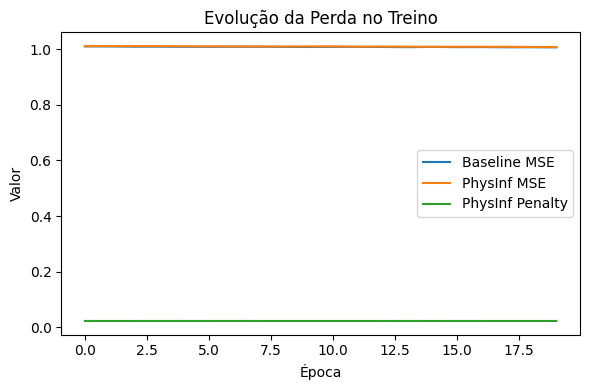

In [27]:
# Avaliação e visualizações completas (célula única)

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader

# 0) Garantir device e nomes das variáveis
device = 'cuda' if torch.cuda.is_available() else 'cpu'
try:
    var_names
except NameError:
    var_names = ['x0', 'x1', 'x2', 'x3']

# 1) (Re)construir test_loader se não existir
try:
    test_loader
except NameError:
    T = data.shape[0] - 1
    split_idx = int(0.8 * T)
    test_data = data[split_idx:]
    test_ds = TimeSeriesDataset(test_data, L)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# 2) Função de avaliação
def evaluate(model, loader, physics=False):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_seq, y in loader:
            x_seq, y = x_seq.to(device), y.to(device)
            if physics:
                y_hat, _ = model(x_seq)
            else:
                y_hat = model(x_seq)
            preds.append(y_hat.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mses = mean_squared_error(trues, preds, multioutput='raw_values')
    maes = mean_absolute_error(trues, preds, multioutput='raw_values')
    r2s  = r2_score(trues, preds, multioutput='raw_values')
    return preds, trues, mses, maes, r2s

# 3) Avaliar ambos os modelos
b_preds, b_trues, b_mse, b_mae, b_r2 = evaluate(baseline, test_loader, physics=False)
p_preds, p_trues, p_mse, p_mae, p_r2 = evaluate(pi_lstm,   test_loader, physics=True)

# 4) Exibir métricas por variável
print("=== Métricas de Desempenho (Teste) ===")
for j, name in enumerate(var_names):
    print(f"\nVariável {name}:")
    print(f"  Baseline       → MSE: {b_mse[j]:.4f}, MAE: {b_mae[j]:.4f}, R²: {b_r2[j]:.4f}")
    print(f"  Phys-Informed  → MSE: {p_mse[j]:.4f}, MAE: {p_mae[j]:.4f}, R²: {p_r2[j]:.4f}")

# 5) Plot: predição vs. valor real
t_test = np.arange(len(b_trues))
for j, name in enumerate(var_names):
    plt.figure(figsize=(10, 3))
    plt.plot(t_test, b_trues[:, j], 'k-',  label='Verdadeiro', linewidth=1)
    plt.plot(t_test, b_preds[:, j], 'r--', label='Baseline')
    plt.plot(t_test, p_preds[:, j], 'b-.', label='PhysInf')
    plt.title(f"Predição de {name} no Teste")
    plt.xlabel("Amostra")
    plt.ylabel(name)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 6) Plot das curvas de treinamento (se existir histórico)
try:
    plt.figure(figsize=(6, 4))
    plt.plot(hist_b['mse'], label='Baseline MSE')
    plt.plot(hist_p['mse'], label='PhysInf MSE')
    plt.plot(hist_p['pen'], label='PhysInf Penalty')
    plt.title("Evolução da Perda no Treino")
    plt.xlabel("Época")
    plt.ylabel("Valor")
    plt.legend()
    plt.tight_layout()
    plt.show()
except NameError:
    print("⚠️ hist_b/hist_p não encontrados. Para plotar curvas de treino, execute train_history antes.")
